# PREVISION DE LA CONSOMMATION D'ELECTRICITE

## Import des packages

In [1]:
import xgboost as xgb
import Fonctions_RTE
from os import walk
import pandas as pd
import numpy as np
import pywt
from collections import Counter
from openpyxl import load_workbook
from datetime import timedelta, date
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import time
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import normalize
import timeit
from sklearn import preprocessing
import pickle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Date et région

In [53]:
names = "B"
date_a_prédire = "2017-06-23"

datetime_prediction = Fonctions_RTE.date_to_date(date_a_prédire)
datetime_prediction2 = datetime_prediction + timedelta(days=1)

## Meteo source externe : 

In [3]:
files = []
for (dirpath, dirnames, filenames) in walk("C:/Users/yoan6/Documents/RTE_CHALLENGE/meteo2"):
    files.extend(filenames)
    break
météo2 = Fonctions_RTE.meteo_externe_grab(files)
météo2.to_csv(date_a_prédire+"meteo.csv", sep=";")

Index(['numer_sta', 'Date', 'Date_time', 'ff_7005', 't_7005', 'u_7005',
       'rr1_7005', 'rr3_7005', 't_7015', 'ff_7015',
       ...
       't_7690', 'ff_7690', 'u_7690', 'rr1_7690', 'rr3_7690', 't_7747',
       'ff_7747', 'u_7747', 'rr1_7747', 'rr3_7747'],
      dtype='object', length=203)


## Meteo RTE : 

In [4]:
newfiles = ['meteo07-21.csv']

In [5]:
meteo = pd.read_csv('C:/Users/Yoan6/Documents/RTE_CHALLENGE/meteo_rte/df_meteo_full_finale2.csv', delimiter=';')
if len(newfiles)!=0:
    meteo = Fonctions_RTE.meteo_rte_add(dataset=meteo, newfiles = newfiles)

In [ ]:
meteo.to_csv('C:/Users/Yoan6/Documents/RTE_CHALLENGE/meteo_rte/df_meteo_full_finale2.csv', sep=";")

## Téléchargement des bases de consommation

In [ ]:
Fonctions_RTE.download_conso()

## Base de données de prix : 

In [ ]:
#test = Fonctions_RTE.prix_processing(date=date_a_prédire)

# FONCTION RUN_ALL

________

In [6]:
def run_all(région, date, meteo=meteo, météo2 = météo2):
    names = région
    date_a_prédire = date
    datetime_prediction = Fonctions_RTE.date_to_date(date_a_prédire)
    datetime_prediction2 = datetime_prediction + timedelta(days=1)
    df1, df2, df3, df4, df5 = Fonctions_RTE.import_(names = names)
    df5 = df5.replace(["ND", "-"], np.NaN)
    indexes = df5.loc[((df5.Heures.astype(str)=="23:30:00")|(df5.Heures.astype(str)=="23:45:00")|(df5.Heures.astype(str)=="23:15:00"))&(pd.isnull(df5.Consommation))].index.tolist()
    rolling = []
    for index in indexes :
        rolling.append((df5.Consommation[index-7:index-1].mean() + df5.Consommation[index+1:index+7].mean())/2)
    df5.loc[((df5.Heures.astype(str)=="23:30:00")|(df5.Heures.astype(str)=="23:45:00")|(df5.Heures.astype(str)=="23:15:00"))&(pd.isnull(df5.Consommation)), "Consommation"] = rolling

    df5 = pd.concat([df5[df5.Date < date_a_prédire], pd.DataFrame(np.arange(1, 97, 1))], 0)
    df5 = df5.reset_index(drop=True)

    df5.loc[pd.isnull(df5.Date), "Date"] = pd.to_datetime(date_a_prédire)
    df5.loc[pd.isnull(df5.Heures), "Heures"] = df4.Heures.unique().tolist()
    df5.loc[pd.isnull(df5.Périmètre), "Périmètre"] = df4.Périmètre

    df = pd.concat([df1, df2, df3, df4, df5], 0)
    df = df.reset_index()
    
    heures = df4[0:96].Heures.astype(str).tolist()
    df = Fonctions_RTE.selection_manquants(df, date_a_prédire, datetime_prediction = datetime_prediction, heures=heures)
    
    df = df.replace(["-", "ND"], np.NaN)
    df[["Consommation"]] = df[["Consommation"]].fillna(method='ffill')
    df.Consommation = df.Consommation.astype(float)
    df["Consommation"] = df["Consommation"].fillna(method='ffill')
    df = Fonctions_RTE.gestion_dates(df)
    df = pd.concat([df, pd.get_dummies(df["Dayofweek"], prefix="Day")], 1)
    df = pd.concat([df, pd.get_dummies(df["Hour"], prefix="Hour")], 1)
    df = pd.concat([df, pd.get_dummies(df["Year"], prefix="Year")], 1)
    df = pd.concat([df, pd.get_dummies(df["Month"], prefix="Month")], 1)
    heuresliste = df.Heures.astype(str).unique().tolist() 
    df.index = df.Date_time
    
    vac = Fonctions_RTE.grab_vac()
    df["UN"] = df.Year.astype(str) + " " + df.Month.astype(str) + " " + df.Day.astype(str) #On le crée sur la base RTE
    df.index = df.UN # On l'indexe
    df = df.merge(vac[["France", "UN"]],  how='left',right_on='UN', left_index=True) # On merge le tout
    df = df.drop_duplicates(subset=['Date_time'])
    df.France = df.France.replace([np.NaN, "X*", "X(1)", "X"], [0, 1, 1, 1])
    df= df.reset_index(drop=True)
    df.index = df.Date_time
    df["Non_travail"] = 0
    df.loc[df.Day == 6, "Non_travail"] = 3
    df.loc[df.Day == 5, "Non_travail"] = 3
    df.loc[df.France == 1, "Non_travail"] = 3
    df["Tempo"] = df["Non_travail"].shift(96)
    df.Tempo = df.Tempo.replace(np.NaN, 9999999)
    df["Tempo2"] = df["Non_travail"].shift(-96)
    df.Tempo2 = df.Tempo2.replace(np.NaN, 9999999)
    df.loc[(df.Tempo == 3)&(df.Tempo2 == 3), "Non_travail"] = 2
    df.loc[(df.Tempo2 == 3), "Non_travail"] = 1
    df = df.drop(["Tempo", "Tempo2"], 1)

    plt.subplots(figsize=(20,6))
    plt.plot(df.Consommation.tail(96*30), color="r", alpha=0.5, label="Consommation avant nettoyage")
    plt.legend()
    plt.title("Consommation depuis 2013 avant nettoyage", fontsize='xx-large', color='b')
    plt.show()
    
    
    
#    df["year_before_cons"] = df.Consommation.shift(96*365)
#    df = df.reset_index(drop=True)
#    df["days_before_mean_cons3"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on="Consommation")
#    df["days_before_mean_cons4"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=8, on='Consommation')
#    df["days_before_mean_cons5"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=5, on='Consommation') * 2

#    df["Day_before"] = df["Consommation"].shift(96)
#    df.loc[0:95, "Day_before"] = 0
#    df["rolling_std"] = df["Day_before"].rolling(window=96).std()
#    df["rolling_std"] = df["rolling_std"].replace(np.NaN, 0)
#    df["rolling_std2"] = df["Day_before"].rolling(window=672).std()
#    df["rolling_std2"] = df["rolling_std"].replace(np.NaN, 0)
#    df["Conso_median1"] = df.Consommation.rolling(window=96).median()
#    df["Conso_median2"] = df.Consommation.rolling(window=96*4).median()
#    df["Conso_median3"] = df.Consommation.rolling(window=96*7).median()
#    df["Conso_median4"] = df.Consommation.rolling(window=96*364).median()

    df = df.reset_index(drop=True)
    df["Ech. physiques"] = df.rename(columns={'Ech. physiques':'Ech_phys'}, inplace=True)
    colonnes = ['Nucléaire', "Thermique", "Eolien", "Solaire", "Hydraulique", "Pompage", "Bioénergies", "Ech_phys"]
    for col in colonnes:
        df = Fonctions_RTE.fill_shift_replace_float(df, serie = col)

    df["Prod_totale_lag1"] = df["Nucléaire_lag1"]  + df.Thermique_lag1 + df.Eolien_lag1 + df.Solaire_lag1 + df.Hydraulique_lag1 + df.Pompage_lag1 + df.Bioénergies_lag1 + df.Ech_phys_lag1                                                        
    df["Prod_totale_lag2"] = df["Prod_totale_lag1"].shift(96*4)
    df["Prod_totale_lag3"] = df["Prod_totale_lag1"].shift(96*364)

    df["Prod_totale_rolling1"] = df.Prod_totale_lag1.rolling(window=96).mean()
    df["Prod_totale_rolling2"] = df.Prod_totale_lag1.rolling(window=96*4).mean()
    df["Prod_totale_rolling3"] = df.Prod_totale_lag1.rolling(window=96*7).mean()

    df["Prod_totale_rolling1m"] = df.Prod_totale_lag1.rolling(window=96).median()
    df["Prod_totale_rolling2m"] = df.Prod_totale_lag1.rolling(window=96*4).median()
    df["Prod_totale_rolling3m"] = df.Prod_totale_lag1.rolling(window=96*7).median()

    df = df.drop(["Thermique", "Solaire", "Eolien", "Hydraulique", "Pompage", "Bioénergies", "Ech_phys", "Thermique_lag1", "Eolien_lag1", "Solaire_lag1",
                     "Hydraulique_lag1", "Pompage_lag1", "Bioénergies_lag1", "Ech_phys_lag1"], 1)
    df = df.replace(np.NaN, 9999999)

    df["Vacances_A"] = 0
    df["Vacances_A"].loc[(df.Date >= "2012-02-11")&(df.Date < "2012-02-27")] = 1
    df["Vacances_A"].loc[(df.Date >= "2012-04-07")&(df.Date < "2012-04-23")] = 1
    df["Vacances_A"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

    df["Vacances_A"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
    df["Vacances_A"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
    df["Vacances_A"].loc[(df.Date >= "2013-02-23")&(df.Date < "2013-03-11")] = 1
    df["Vacances_A"].loc[(df.Date >= "2013-04-20")&(df.Date < "2013-05-06")] = 1
    df["Vacances_A"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

    df["Vacances_A"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
    df["Vacances_A"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
    df["Vacances_A"].loc[(df.Date >= "2014-03-01")&(df.Date < "2014-03-17")] = 1
    df["Vacances_A"].loc[(df.Date >= "2014-04-26")&(df.Date < "2014-05-12")] = 1
    df["Vacances_A"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

    df["Vacances_A"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
    df["Vacances_A"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
    df["Vacances_A"].loc[(df.Date >= "2015-02-07")&(df.Date < "2015-02-23")] = 1
    df["Vacances_A"].loc[(df.Date >= "2015-04-11")&(df.Date < "2015-04-27")] = 1
    df["Vacances_A"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

    df["Vacances_A"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
    df["Vacances_A"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
    df["Vacances_A"].loc[(df.Date >= "2016-02-13")&(df.Date < "2016-02-29")] = 1
    df["Vacances_A"].loc[(df.Date >= "2016-04-09")&(df.Date < "2016-04-25")] = 1
    df["Vacances_A"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
    df["Vacances_A"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

    df["Vacances_A"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
    df["Vacances_A"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
    df["Vacances_A"].loc[(df.Date >= "2017-02-18")&(df.Date < "2017-03-06")] = 1
    df["Vacances_A"].loc[(df.Date >= "2017-04-15")&(df.Date < "2017-05-02")] = 1
    df["Vacances_A"].loc[(df.Date >= "2017-07-08")] = 1
    df["Vacances_B"] = 0
    df["Vacances_B"].loc[(df.Date >= "2012-02-25")&(df.Date < "2012-03-12")] = 1
    df["Vacances_B"].loc[(df.Date >= "2012-04-21")&(df.Date < "2012-05-07")] = 1
    df["Vacances_B"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

    df["Vacances_B"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
    df["Vacances_B"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
    df["Vacances_B"].loc[(df.Date >= "2013-02-16")&(df.Date < "2013-03-04")] = 1
    df["Vacances_B"].loc[(df.Date >= "2013-04-13")&(df.Date < "2013-04-29")] = 1
    df["Vacances_B"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

    df["Vacances_B"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
    df["Vacances_B"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
    df["Vacances_B"].loc[(df.Date >= "2014-02-22")&(df.Date < "2014-03-10")] = 1
    df["Vacances_B"].loc[(df.Date >= "2014-04-19")&(df.Date < "2014-05-05")] = 1
    df["Vacances_B"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

    df["Vacances_B"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
    df["Vacances_B"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
    df["Vacances_B"].loc[(df.Date >= "2015-02-21")&(df.Date < "2015-03-09")] = 1
    df["Vacances_B"].loc[(df.Date >= "2015-04-25")&(df.Date < "2015-05-11")] = 1
    df["Vacances_B"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

    df["Vacances_B"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
    df["Vacances_B"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
    df["Vacances_B"].loc[(df.Date >= "2016-02-06")&(df.Date < "2016-02-22")] = 1
    df["Vacances_B"].loc[(df.Date >= "2016-04-02")&(df.Date < "2016-04-18")] = 1
    df["Vacances_B"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
    df["Vacances_B"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

    df["Vacances_B"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
    df["Vacances_B"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
    df["Vacances_B"].loc[(df.Date >= "2017-02-11")&(df.Date < "2017-02-27")] = 1
    df["Vacances_B"].loc[(df.Date >= "2017-04-08")&(df.Date < "2017-04-24")] = 1
    df["Vacances_B"].loc[(df.Date >= "2017-07-08")] = 1
    df["Vacances_C"] = 0
    df["Vacances_C"].loc[(df.Date >= "2012-02-18")&(df.Date < "2012-03-05")] = 1
    df["Vacances_C"].loc[(df.Date >= "2012-04-14")&(df.Date < "2012-04-30")] = 1
    df["Vacances_C"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

    df["Vacances_C"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
    df["Vacances_C"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
    df["Vacances_C"].loc[(df.Date >= "2013-03-02")&(df.Date < "2013-03-18")] = 1
    df["Vacances_C"].loc[(df.Date >= "2013-04-27")&(df.Date < "2013-05-03")] = 1
    df["Vacances_C"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

    df["Vacances_C"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
    df["Vacances_C"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
    df["Vacances_C"].loc[(df.Date >= "2014-02-15")&(df.Date < "2014-03-03")] = 1
    df["Vacances_C"].loc[(df.Date >= "2014-04-12")&(df.Date < "2014-04-28")] = 1
    df["Vacances_C"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

    df["Vacances_C"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
    df["Vacances_C"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
    df["Vacances_C"].loc[(df.Date >= "2015-02-14")&(df.Date < "2015-03-02")] = 1
    df["Vacances_C"].loc[(df.Date >= "2015-04-18")&(df.Date < "2015-05-04")] = 1
    df["Vacances_C"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

    df["Vacances_C"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
    df["Vacances_C"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
    df["Vacances_C"].loc[(df.Date >= "2016-02-20")&(df.Date < "2016-03-07")] = 1
    df["Vacances_C"].loc[(df.Date >= "2016-04-16")&(df.Date < "2016-05-02")] = 1
    df["Vacances_C"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
    df["Vacances_C"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

    df["Vacances_C"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
    df["Vacances_C"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
    df["Vacances_C"].loc[(df.Date >= "2017-02-04")&(df.Date < "2017-02-20")] = 1
    df["Vacances_C"].loc[(df.Date >= "2017-04-01")&(df.Date < "2017-04-18")] = 1
    df["Vacances_C"].loc[(df.Date >= "2017-07-08")] = 1
    
    df = df.reset_index(drop=True)
    df.Consommation = Fonctions_RTE.get_median_filtered(df.Consommation, 6)
    df[["Consommation"]] = df[["Consommation"]].fillna(method='ffill') 
    df["Consommation"] = df.Consommation.fillna(method='bfill')
    plt.subplots(figsize=(20,6))
    plt.plot(df.Consommation.tail(96*30), color='b', alpha=0.5, label="Consommation après nettoyage")
    plt.legend()
    plt.show()
    
    
    df["year_before_cons"] = df.Consommation.shift(96*365)
    df = df.reset_index(drop=True)
    df["days_before_mean_cons3"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on="Consommation")
    df["days_before_mean_cons4"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=8, on='Consommation')
    df["days_before_mean_cons5"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=5, on='Consommation') * 2

    df["Day_before"] = df["Consommation"].shift(96)
    df.loc[0:95, "Day_before"] = 0
    df["rolling_std"] = df["Day_before"].rolling(window=96).std()
    df["rolling_std"] = df["rolling_std"].replace(np.NaN, 0)
    df["rolling_std2"] = df["Day_before"].rolling(window=672).std()
    df["rolling_std2"] = df["rolling_std"].replace(np.NaN, 0)
    df["Conso_median1"] = df.Consommation.rolling(window=96).median()
    df["Conso_median2"] = df.Consommation.rolling(window=96*4).median()
    df["Conso_median3"] = df.Consommation.rolling(window=96*7).median()
    df["Conso_median4"] = df.Consommation.rolling(window=96*364).median()

    df.index = df.Date_time    
    df[pd.isnull(df["year_before_cons"])] = df[pd.isnull(df["year_before_cons"])].replace(np.NaN, df.loc["2013-01-01 00:30:00", "Consommation"])
    df = df.reset_index(drop=True)
    
    coeffs = pywt.swt(df.Consommation.values, 'db3', level=1)
    wave = pd.DataFrame({"cA":coeffs[0][0], "cD":coeffs[0][1]})
    wave["cD0"] = 0  
    x = np.array(wave.cA)
    plt.plot(x)
    plt.show()
    y = np.array(wave.cD0)
    z = [(x, y)]
    res = pywt.iswt(z, 'db3')
    wave.loc[-10:, 'cD'] = 0
    df = df.reset_index(drop=True)
    df["SmoothWave"] = res
    df["cA"] = wave.cA.shift(96)
    df["cD"] = wave.cD.shift(96)
    df["cD_nolag"] = wave.cD
    df["cA_nolag"] = wave.cA
    df["cA_rollingmean"] = wave.cA.rolling(window=96).mean()
    df.cA_rollingmean = df.cA_rollingmean.replace(np.NaN, 9999999)
    df["cD_rollingmean"] = wave.cD.rolling(window=96).mean()
    df.cD_rollingmean = df.cD_rollingmean.replace(np.NaN, 9999999)
    df["cA_rollingstd"] = wave.cA.rolling(window=96).std()
    df.cA_rollingstd = df.cA_rollingstd.replace(np.NaN, 9999999)
    df["cD_rollingstd"] = wave.cD.rolling(window=96).std()
    df.cD_rollingstd = df.cD_rollingstd.replace(np.NaN, 9999999)
    
    
    df["cA_before_mean_cons"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on='cA_nolag')
    df["SmoothWave_before_mean_cons"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on='SmoothWave')
    #df["cD_rolling_min"] = rolling_days_before(df = df, on='cD_nolag', method='min')
    #df["cD_rolling_max"] = rolling_days_before(df = df, on='cD_nolag', method='max')
    #df["cD_rolling_etendue"] = df["cD_rolling_max"] - df["cD_rolling_min"]
    df.SmoothWave = df.SmoothWave.shift(96)
    
    tempo1 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20112012.xlsx")
    tempo2 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20122013.xlsx")
    tempo3 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20132014.xlsx")
    tempo4 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20142015.xlsx")
    tempo5 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20152016.xlsx")
    tempo6 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20162017.xlsx")
    tempo1.columns = ["Dates", "Couleur"]
    tempo2.columns = ["Dates", "Couleur"]
    tempo3.columns = ["Dates", "Couleur"]
    tempo4.columns = ["Dates", "Couleur"]
    tempo5.columns = ["Dates", "Couleur"]
    tempo6.columns = ["Dates", "Couleur"]
    tempo = pd.concat([tempo1, tempo2, tempo3, tempo4, tempo5, tempo6], 0)
    tempo = tempo.drop([365, 366, 263], 0)
    tempo[(tempo.Couleur != "BLEU")&(tempo.Couleur !="ROUGE")&(tempo.Couleur != "BLANC")]
    tempo = tempo.reset_index(drop=True)
    tempo.Dates = pd.to_datetime(tempo.Dates)
    tempo.Dates = tempo.Dates.dt.strftime("%Y-%m-%d")
    tempo.index = tempo.Dates
    df.index = df.Date
    df = df.merge(tempo, how='left', right_index=True, left_index=True)
    df.index = df.Date_time
    df.loc[pd.isnull(df.Couleur), "Couleur"] = "BLEU"
    df = pd.concat([df, pd.get_dummies(df.Couleur)],axis=1)
    df = df.reset_index(drop=True)
    #meteo = meteo[["date_base", names+"_TEMP", names+"_NEBU"]]
    meteo = meteo.drop_duplicates(subset=['date_base'], keep='last')             
    meteo.date_base = pd.to_datetime(meteo.date_base)
    meteo["indexing"] = meteo.date_base.dt.year.astype(str) + meteo.date_base.dt.month.astype(str) + meteo.date_base.dt.day.astype(str) + meteo.date_base.dt.hour.astype(str)
    df["indexing"] = df.Date_time.dt.year.astype(str) + df.Date_time.dt.month.astype(str) + df.Date_time.dt.day.astype(str) + df.Date_time.dt.hour.astype(str)
    meteo.index = meteo.indexing
    df.index = df.indexing
    df = df.merge(meteo[["date_base", names+"_TEMP", names+"_NEBU"]], how='left', left_on='indexing', right_index=True)
    df = df.reset_index(drop=True)
    #df = df.drop(['indexing_x', 'indexing_y'], 1)
    df[[names+"_TEMP"]] = df[[names+"_TEMP"]].fillna(method='ffill')
    df["MEAN_TEMP"] = df[names+"_TEMP"]
    df = df.replace(np.NaN, 9999999)
    df = df.drop_duplicates(subset=(["Date_time"]))

    df["temp_lag3"] = df[names+"_TEMP"].shift(48)
    df["temp_lag4"] = df[names+"_TEMP"].shift(96)
    df["temp_rolling3"] = df[names+"_TEMP"].rolling(window=672).mean()
    df["temp_rolling4"] = df[names+"_TEMP"].rolling(window=1440).mean()
    df["temp_max1"] = df[names+"_TEMP"].rolling(window=96).max()
    df["temp_max2"] = df[names+"_TEMP"].rolling(window=672).max()
    df["temp_min1"] = df[names+"_TEMP"].rolling(window=96).min()
    df["temp_min2"] = df[names+"_TEMP"].rolling(window=672).min()    
    df["temp_max3"] = df["temp_max1"].rolling(window=96).max()
    df["temp_max4"] = df["temp_max1"].rolling(window=672).max()
    df["temp_max5"] = df["temp_max1"].rolling(window=1440).max()
    df[[names+"_NEBU"]] = df[[names+"_NEBU"]].fillna(method='ffill')
    df["MEAN_NEBU"] = df[names+"_NEBU"]
    df = df.replace(np.NaN, 9999999)
    df = df.drop_duplicates(subset=(["Date_time"]))
    df["nebu_lag3"] = df[names+"_NEBU"].shift(48)
    df["nebu_lag4"] = df[names+"_NEBU"].shift(96)
    df["nebu_rolling3"] = df[names+"_NEBU"].rolling(window=672).mean()
    df["nebu_rolling4"] = df[names+"_NEBU"].rolling(window=1440).mean()
    df["nebu_max1"] = df[names+"_NEBU"].rolling(window=96).max()
    df["nebu_max2"] = df[names+"_NEBU"].rolling(window=672).max()
    df["nebu_max3"] = df["nebu_max1"].rolling(window=96).max()
    df["nebu_max4"] = df["nebu_max1"].rolling(window=672).max()
    df["nebu_max5"] = df["nebu_max1"].rolling(window=1440).max()
    df["nebu_min1"] = df[names+"_NEBU"].rolling(window=96).min()
    df["nebu_min2"] = df[names+"_NEBU"].rolling(window=672).min()
    
    if not names+'_Mean_t' in df:
        print("Première fois")
        df["Date_météo2"] = df.Date_time
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("15:00", "00:00")   
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("30:00", "00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("45:00", "00:00")        

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("01:00:00", "00:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("02:00:00", "00:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("04:00:00", "03:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("05:00:00", "03:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("07:00:00", "06:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("08:00:00", "06:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("10:00:00", "09:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("11:00:00", "09:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("13:00:00", "12:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("14:00:00", "12:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("16:00:00", "15:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("17:00:00", "15:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("19:00:00", "18:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("20:00:00", "18:00:00")      

        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("22:00:00", "21:00:00")                                                                                                              
        df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("23:00:00", "21:00:00")      

        météo2 = météo2[météo2.Date < (datetime_prediction - timedelta(days=1)).strftime("%Y-%m-%d")]
                        #str(date(int(date_a_prédire[0:4]), int(date_a_prédire[5:7]), int(date_a_prédire[8:10])-1))]
        #météo2 = météo2.drop("Date", 1)
        df.set_index('Date_météo2')
        météo2.index = météo2.Date_météo2
        df = df.merge(météo2[[names+'_Mean_t', names+'_Mean_ff',
                             names+'_Mean_rr1', names+'_Mean_rr3',
                             names+'_Mean_u']], how='left', left_on='Date_météo2', right_index=True)
        df = df.drop_duplicates(subset=['Date_time'])
        df = df.reset_index(drop=True) 
        liste_columns = [names+'_Mean_t', names+'_Mean_ff', names+'_Mean_rr1', names+'_Mean_rr3', names+'_Mean_u']
        df[liste_columns] = df[liste_columns].shift(96*2)

        df["meteo2_temp"] = df[names + "_Mean_t"]
        df["rolling_rr1"] = df[names+"_Mean_rr1"].rolling(window=92*4).mean()
        df["rolling_u"] = df[names+"_Mean_u"].rolling(window=92*4).mean()
        df["rolling_rr3"] = df[names+"_Mean_rr3"].rolling(window=92*4).mean()
        df["rolling_ff"] = df[names+"_Mean_ff"].rolling(window=92*4).mean()
        df = df.replace(np.NaN, 9999999)

    else:   
        pass

    return df

# DATA WRANGLING

C:\ProgramData\Anaconda3\lib\site-packages\pandas\indexes\api.py:71: RuntimeWarning: unorderable types: str() < int(), sort order is undefined for incomparable objects
  result = result.union(other)


manquants pour aujourd'hui :  0 soit à partir de  00:00:00


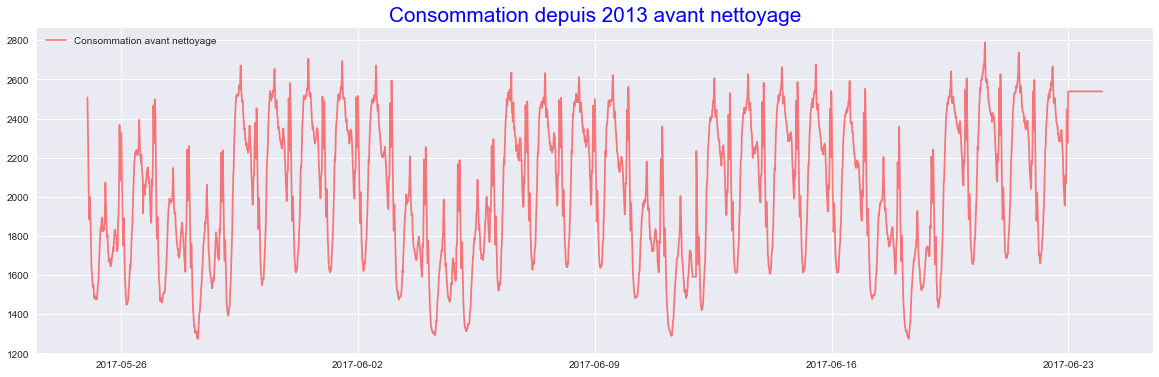

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Nombre de modifications :  2


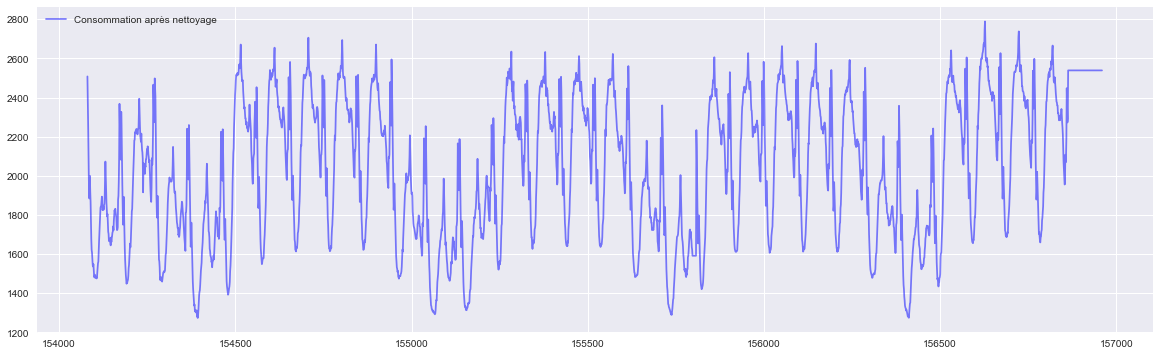

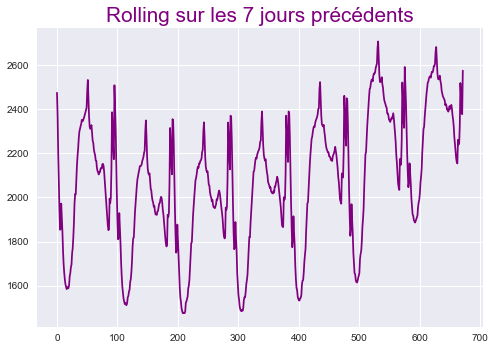

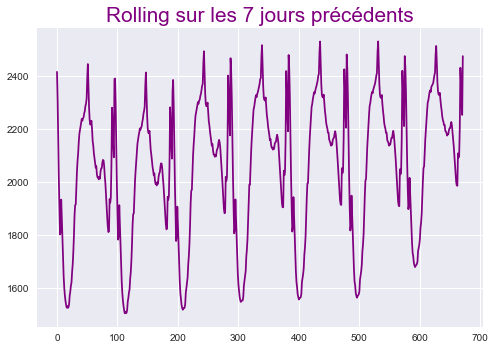

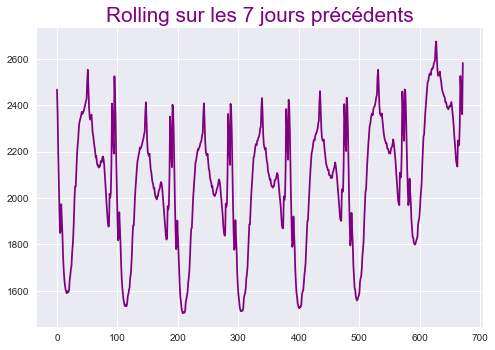

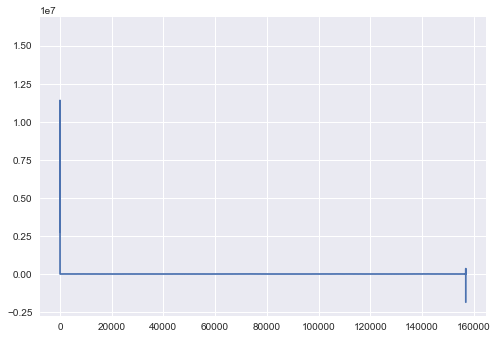

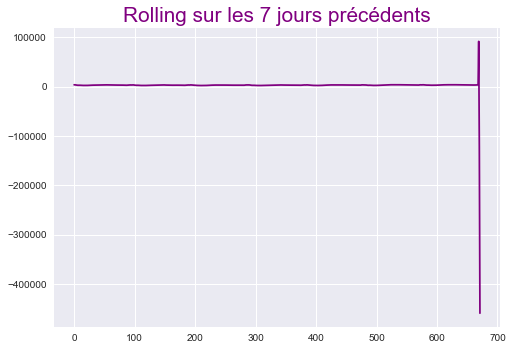

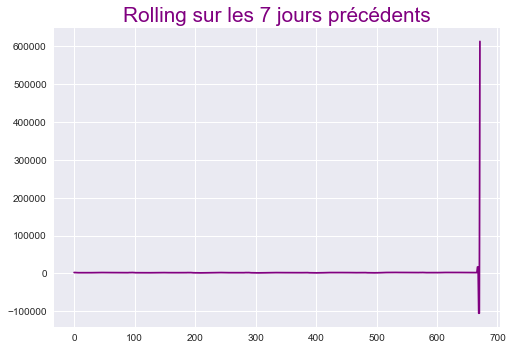

Première fois


In [54]:
df = run_all(région= names, date = date_a_prédire, meteo = meteo, météo2 = météo2)

# DATA WRANGLIN (sans fonction)

## Création de la base : 

In [1]:

df1, df2, df3, df4, df5 = Fonctions_RTE.import_(names = names)
df5 = df5.replace(["ND", "-"], np.NaN)
indexes = df5.loc[((df5.Heures.astype(str)=="23:30:00")|(df5.Heures.astype(str)=="23:45:00")|(df5.Heures.astype(str)=="23:15:00"))&(pd.isnull(df5.Consommation))].index.tolist()
rolling = []
for index in indexes :
    rolling.append((df5.Consommation[index-7:index-1].mean() + df5.Consommation[index+1:index+7].mean())/2)
df5.loc[((df5.Heures.astype(str)=="23:30:00")|(df5.Heures.astype(str)=="23:45:00")|(df5.Heures.astype(str)=="23:15:00"))&(pd.isnull(df5.Consommation)), "Consommation"] = rolling

df5 = pd.concat([df5[df5.Date < date_a_prédire], pd.DataFrame(np.arange(1, 97, 1))], 0)
df5 = df5.reset_index(drop=True)

df5.loc[pd.isnull(df5.Date), "Date"] = pd.to_datetime(date_a_prédire)
df5.loc[pd.isnull(df5.Heures), "Heures"] = df4.Heures.unique().tolist()
df5.loc[pd.isnull(df5.Périmètre), "Périmètre"] = df4.Périmètre

df = pd.concat([df1, df2, df3, df4, df5], 0)
df = df.reset_index()

SyntaxError: invalid syntax (<ipython-input-1-b553334bf215>, line 1)

In [ ]:
heures = df4[0:96].Heures.astype(str).tolist()
df = Fonctions_RTE.selection_manquants(df, date_a_prédire, datetime_prediction = datetime_prediction, heures=heures)

In [ ]:
#ATTENTION FONCTIONNE PAS A CORRIGER

In [ ]:
df = df.replace(["-", "ND"], np.NaN)
df[["Consommation"]] = df[["Consommation"]].fillna(method='ffill')
df.Consommation = df.Consommation.astype(float)

In [ ]:
df = Fonctions_RTE.gestion_dates(df)

In [ ]:
df = pd.concat([df, pd.get_dummies(df["Dayofweek"], prefix="Day")], 1)
df = pd.concat([df, pd.get_dummies(df["Hour"], prefix="Hour")], 1)
df = pd.concat([df, pd.get_dummies(df["Year"], prefix="Year")], 1)
df = pd.concat([df, pd.get_dummies(df["Month"], prefix="Month")], 1)

In [ ]:
heuresliste = df.Heures.astype(str).unique().tolist() 
#df["Prix_EPEX"] = test.Prix
#df["Quant_EPEX"] = test.QUANT
#df["day_before_PEPEX"] = df.Prix_EPEX.shift(96).replace(np.NaN, 0)
#df["year_before_PEPEX"] = df.Prix_EPEX.shift(96*365)
#df["days_before_mean_PEPEX2"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on='Prix_EPEX')    
#df["days_before_mean_QEPEX2"] = Fonctions_RTE.rolling_days_before(df,heuresliste, on='Quant_EPEX')

df.index = df.Date_time
#df["day_before_QEPEX"] = df.Quant_EPEX.shift(96).replace(np.NaN, 0)
#df["year_before_QEPEX"] = df.Quant_EPEX.shift(96*365)
#df[pd.isnull(df["year_before_QEPEX"])] = df[pd.isnull(df["year_before_QEPEX"])].replace(np.NaN, df.loc["2013-01-01 00:30:00", "Quant_EPEX"])
#df[pd.isnull(df["year_before_PEPEX"])] = df[pd.isnull(df["year_before_PEPEX"])].replace(np.NaN, df.loc["2013-01-01 00:30:00", "Prix_EPEX"])



In [ ]:
vac = Fonctions_RTE.grab_vac()
df["UN"] = df.Year.astype(str) + " " + df.Month.astype(str) + " " + df.Day.astype(str) #On le crée sur la base RTE
df.index = df.UN # On l'indexe
df = df.merge(vac[["France", "UN"]],  how='left',right_on='UN', left_index=True) # On merge le tout
df = df.drop_duplicates(subset=['Date_time'])
df.France = df.France.replace([np.NaN, "X*", "X(1)", "X"], [0, 1, 1, 1])
df= df.reset_index(drop=True)
df.index = df.Date_time
df["Non_travail"] = 0
df.loc[df.Day == 6, "Non_travail"] = 3
df.loc[df.Day == 5, "Non_travail"] = 3
df.loc[df.France == 1, "Non_travail"] = 3
df["Tempo"] = df["Non_travail"].shift(96)
df.Tempo = df.Tempo.replace(np.NaN, 9999999)
df["Tempo2"] = df["Non_travail"].shift(-96)
df.Tempo2 = df.Tempo2.replace(np.NaN, 9999999)
df.loc[(df.Tempo == 3)&(df.Tempo2 == 3), "Non_travail"] = 2
df.loc[(df.Tempo2 == 3), "Non_travail"] = 1
df = df.drop(["Tempo", "Tempo2"], 1)


In [ ]:
plt.subplots(figsize=(20,6))
plt.plot(df.Consommation.tail(96*30), color="r", alpha=0.5, label="Consommation avant nettoyage")
plt.legend()
plt.title("Consommation depuis 2013 avant nettoyage", fontsize='xx-large', color='b')
plt.show()

In [ ]:
df["year_before_cons"] = df.Consommation.shift(96*365)
df = df.reset_index(drop=True)
df["days_before_mean_cons3"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on="Consommation")
df["days_before_mean_cons4"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=8, on='Consommation')
df["days_before_mean_cons5"] = Fonctions_RTE.rolling_days_before(df, heuresliste, days=5, on='Consommation') * 2

df["Day_before"] = df["Consommation"].shift(96)
df.loc[0:95, "Day_before"] = 0
df["rolling_std"] = df["Day_before"].rolling(window=96).std()
df["rolling_std"] = df["rolling_std"].replace(np.NaN, 0)
df["rolling_std2"] = df["Day_before"].rolling(window=672).std()
df["rolling_std2"] = df["rolling_std"].replace(np.NaN, 0)
df["Conso_median1"] = df.Consommation.rolling(window=96).median()
df["Conso_median2"] = df.Consommation.rolling(window=96*4).median()
df["Conso_median3"] = df.Consommation.rolling(window=96*7).median()
df["Conso_median4"] = df.Consommation.rolling(window=96*364).median()

df.index = df.Date_time    
df[pd.isnull(df["year_before_cons"])] = df[pd.isnull(df["year_before_cons"])].replace(np.NaN, df.loc["2013-01-01 00:30:00", "Consommation"])
df = df.reset_index(drop=True)

In [ ]:
df["Ech. physiques"] = df.rename(columns={'Ech. physiques':'Ech_phys'}, inplace=True)
colonnes = ['Nucléaire', "Thermique", "Eolien", "Solaire", "Hydraulique", "Pompage", "Bioénergies", "Ech_phys"]
for col in colonnes:
    df = Fonctions_RTE.fill_shift_replace_float(df, serie = col)
    
df["Prod_totale_lag1"] = df["Nucléaire_lag1"]  + df.Thermique_lag1 + df.Eolien_lag1 + df.Solaire_lag1 + df.Hydraulique_lag1 + df.Pompage_lag1 + df.Bioénergies_lag1 + df.Ech_phys_lag1                                                        
df["Prod_totale_lag2"] = df["Prod_totale_lag1"].shift(96*4)
df["Prod_totale_lag3"] = df["Prod_totale_lag1"].shift(96*364)

df["Prod_totale_rolling1"] = df.Prod_totale_lag1.rolling(window=96).mean()
df["Prod_totale_rolling2"] = df.Prod_totale_lag1.rolling(window=96*4).mean()
df["Prod_totale_rolling3"] = df.Prod_totale_lag1.rolling(window=96*7).mean()
    
df["Prod_totale_rolling1m"] = df.Prod_totale_lag1.rolling(window=96).median()
df["Prod_totale_rolling2m"] = df.Prod_totale_lag1.rolling(window=96*4).median()
df["Prod_totale_rolling3m"] = df.Prod_totale_lag1.rolling(window=96*7).median()
    
df = df.drop(["Thermique", "Solaire", "Eolien", "Hydraulique", "Pompage", "Bioénergies", "Ech_phys", "Thermique_lag1", "Eolien_lag1", "Solaire_lag1",
                 "Hydraulique_lag1", "Pompage_lag1", "Bioénergies_lag1", "Ech_phys_lag1"], 1)
df = df.replace(np.NaN, 9999999)

df["Vacances_A"] = 0
df["Vacances_A"].loc[(df.Date >= "2012-02-11")&(df.Date < "2012-02-27")] = 1
df["Vacances_A"].loc[(df.Date >= "2012-04-07")&(df.Date < "2012-04-23")] = 1
df["Vacances_A"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

df["Vacances_A"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
df["Vacances_A"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
df["Vacances_A"].loc[(df.Date >= "2013-02-23")&(df.Date < "2013-03-11")] = 1
df["Vacances_A"].loc[(df.Date >= "2013-04-20")&(df.Date < "2013-05-06")] = 1
df["Vacances_A"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

df["Vacances_A"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
df["Vacances_A"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
df["Vacances_A"].loc[(df.Date >= "2014-03-01")&(df.Date < "2014-03-17")] = 1
df["Vacances_A"].loc[(df.Date >= "2014-04-26")&(df.Date < "2014-05-12")] = 1
df["Vacances_A"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

df["Vacances_A"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
df["Vacances_A"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
df["Vacances_A"].loc[(df.Date >= "2015-02-07")&(df.Date < "2015-02-23")] = 1
df["Vacances_A"].loc[(df.Date >= "2015-04-11")&(df.Date < "2015-04-27")] = 1
df["Vacances_A"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

df["Vacances_A"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
df["Vacances_A"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
df["Vacances_A"].loc[(df.Date >= "2016-02-13")&(df.Date < "2016-02-29")] = 1
df["Vacances_A"].loc[(df.Date >= "2016-04-09")&(df.Date < "2016-04-25")] = 1
df["Vacances_A"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
df["Vacances_A"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

df["Vacances_A"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
df["Vacances_A"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
df["Vacances_A"].loc[(df.Date >= "2017-02-18")&(df.Date < "2017-03-06")] = 1
df["Vacances_A"].loc[(df.Date >= "2017-04-15")&(df.Date < "2017-05-02")] = 1
df["Vacances_A"].loc[(df.Date >= "2017-07-08")] = 1
df["Vacances_B"] = 0
df["Vacances_B"].loc[(df.Date >= "2012-02-25")&(df.Date < "2012-03-12")] = 1
df["Vacances_B"].loc[(df.Date >= "2012-04-21")&(df.Date < "2012-05-07")] = 1
df["Vacances_B"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

df["Vacances_B"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
df["Vacances_B"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
df["Vacances_B"].loc[(df.Date >= "2013-02-16")&(df.Date < "2013-03-04")] = 1
df["Vacances_B"].loc[(df.Date >= "2013-04-13")&(df.Date < "2013-04-29")] = 1
df["Vacances_B"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

df["Vacances_B"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
df["Vacances_B"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
df["Vacances_B"].loc[(df.Date >= "2014-02-22")&(df.Date < "2014-03-10")] = 1
df["Vacances_B"].loc[(df.Date >= "2014-04-19")&(df.Date < "2014-05-05")] = 1
df["Vacances_B"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

df["Vacances_B"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
df["Vacances_B"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
df["Vacances_B"].loc[(df.Date >= "2015-02-21")&(df.Date < "2015-03-09")] = 1
df["Vacances_B"].loc[(df.Date >= "2015-04-25")&(df.Date < "2015-05-11")] = 1
df["Vacances_B"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

df["Vacances_B"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
df["Vacances_B"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
df["Vacances_B"].loc[(df.Date >= "2016-02-06")&(df.Date < "2016-02-22")] = 1
df["Vacances_B"].loc[(df.Date >= "2016-04-02")&(df.Date < "2016-04-18")] = 1
df["Vacances_B"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
df["Vacances_B"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

df["Vacances_B"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
df["Vacances_B"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
df["Vacances_B"].loc[(df.Date >= "2017-02-11")&(df.Date < "2017-02-27")] = 1
df["Vacances_B"].loc[(df.Date >= "2017-04-08")&(df.Date < "2017-04-24")] = 1
df["Vacances_B"].loc[(df.Date >= "2017-07-08")] = 1
df["Vacances_C"] = 0
df["Vacances_C"].loc[(df.Date >= "2012-02-18")&(df.Date < "2012-03-05")] = 1
df["Vacances_C"].loc[(df.Date >= "2012-04-14")&(df.Date < "2012-04-30")] = 1
df["Vacances_C"].loc[(df.Date >= "2012-07-05")&(df.Date < "2012-09-04")] = 1

df["Vacances_C"].loc[(df.Date >= "2012-10-27")&(df.Date < "2012-11-08")] = 1
df["Vacances_C"].loc[(df.Date >= "2012-12-22")&(df.Date < "2013-01-07")] = 1
df["Vacances_C"].loc[(df.Date >= "2013-03-02")&(df.Date < "2013-03-18")] = 1
df["Vacances_C"].loc[(df.Date >= "2013-04-27")&(df.Date < "2013-05-03")] = 1
df["Vacances_C"].loc[(df.Date >= "2013-07-04")&(df.Date < "2013-09-04")] = 1

df["Vacances_C"].loc[(df.Date >= "2013-10-19")&(df.Date < "2013-11-04")] = 1
df["Vacances_C"].loc[(df.Date >= "2013-12-21")&(df.Date < "2014-01-06")] = 1
df["Vacances_C"].loc[(df.Date >= "2014-02-15")&(df.Date < "2014-03-03")] = 1
df["Vacances_C"].loc[(df.Date >= "2014-04-12")&(df.Date < "2014-04-28")] = 1
df["Vacances_C"].loc[(df.Date >= "2014-07-05")&(df.Date < "2014-09-03")] = 1

df["Vacances_C"].loc[(df.Date >= "2014-10-18")&(df.Date < "2014-11-03")] = 1
df["Vacances_C"].loc[(df.Date >= "2014-12-20")&(df.Date < "2015-01-05")] = 1
df["Vacances_C"].loc[(df.Date >= "2015-02-14")&(df.Date < "2015-03-02")] = 1
df["Vacances_C"].loc[(df.Date >= "2015-04-18")&(df.Date < "2015-05-04")] = 1
df["Vacances_C"].loc[(df.Date >= "2015-07-04")&(df.Date < "2015-09-02")] = 1

df["Vacances_C"].loc[(df.Date >= "2015-10-17")&(df.Date < "2015-11-02")] = 1
df["Vacances_C"].loc[(df.Date >= "2015-12-19")&(df.Date < "2016-01-04")] = 1
df["Vacances_C"].loc[(df.Date >= "2016-02-20")&(df.Date < "2016-03-07")] = 1
df["Vacances_C"].loc[(df.Date >= "2016-04-16")&(df.Date < "2016-05-02")] = 1
df["Vacances_C"].loc[(df.Date >= "2016-05-04")&(df.Date < "2016-05-09")] = 1
df["Vacances_C"].loc[(df.Date >= "2016-07-05")&(df.Date < "2016-09-02")] = 1

df["Vacances_C"].loc[(df.Date >= "2016-10-19")&(df.Date < "2016-11-03")] = 1
df["Vacances_C"].loc[(df.Date >= "2016-12-17")&(df.Date < "2017-01-03")] = 1
df["Vacances_C"].loc[(df.Date >= "2017-02-04")&(df.Date < "2017-02-20")] = 1
df["Vacances_C"].loc[(df.Date >= "2017-04-01")&(df.Date < "2017-04-18")] = 1
df["Vacances_C"].loc[(df.Date >= "2017-07-08")] = 1




_________

## Wavelets :

In [ ]:
coeffs = pywt.swt(df.Consommation, 'db3', level=1)
wave = pd.DataFrame({"cA":coeffs[0][0], "cD":coeffs[0][1]})
wave["cD0"] = 0  
x = np.array(wave.cA)

y = np.array(wave.cD0)
z = [(x, y)]
res = pywt.iswt(z, 'db3')
wave.loc[-10:, 'cD'] = 0
df = df.reset_index(drop=True)
df["SmoothWave"] = res
df["cA"] = wave.cA.shift(96)
df["cD"] = wave.cD.shift(96)
df["cD_nolag"] = wave.cD
df["cA_nolag"] = wave.cA
df["cA_rollingmean"] = wave.cA.rolling(window=96).mean()
df.cA_rollingmean = df.cA_rollingmean.replace(np.NaN, 9999999)
df["cD_rollingmean"] = wave.cD.rolling(window=96).mean()
df.cD_rollingmean = df.cD_rollingmean.replace(np.NaN, 9999999)
df["cA_rollingstd"] = wave.cA.rolling(window=96).std()
df.cA_rollingstd = df.cA_rollingstd.replace(np.NaN, 9999999)
df["cD_rollingstd"] = wave.cD.rolling(window=96).std()
df.cD_rollingstd = df.cD_rollingstd.replace(np.NaN, 9999999)

df["cA_before_mean_cons"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on='cA_nolag')
df["SmoothWave_before_mean_cons"] = Fonctions_RTE.rolling_days_before(df, heuresliste, on='SmoothWave')
#df["cD_rolling_min"] = rolling_days_before(df = df, on='cD_nolag', method='min')
#df["cD_rolling_max"] = rolling_days_before(df = df, on='cD_nolag', method='max')
#df["cD_rolling_etendue"] = df["cD_rolling_max"] - df["cD_rolling_min"]
df.SmoothWave = df.SmoothWave.shift(96)

In [ ]:
df.Consommation = Fonctions_RTE.get_median_filtered(df.Consommation)
df[["Consommation"]] = df[["Consommation"]].fillna(method='ffill')
df = df.reset_index(drop=True)    
plt.subplots(figsize=(20,6))
plt.plot(df.Consommation.tail(96*30), color='b', alpha=0.5, label="Consommation après nettoyage")
plt.legend()
plt.show()
df["Consommation"] = df.Consommation.fillna(method='bfill')

In [ ]:
tempo1 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20112012.xlsx")
tempo2 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20122013.xlsx")
tempo3 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20132014.xlsx")
tempo4 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20142015.xlsx")
tempo5 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20152016.xlsx")
tempo6 = pd.read_excel("D:/Yoan/CONCOURS RTE/tempo20162017.xlsx")
tempo1.columns = ["Dates", "Couleur"]
tempo2.columns = ["Dates", "Couleur"]
tempo3.columns = ["Dates", "Couleur"]
tempo4.columns = ["Dates", "Couleur"]
tempo5.columns = ["Dates", "Couleur"]
tempo6.columns = ["Dates", "Couleur"]
tempo = pd.concat([tempo1, tempo2, tempo3, tempo4, tempo5, tempo6], 0)
tempo = tempo.drop([365, 366, 263], 0)
tempo[(tempo.Couleur != "BLEU")&(tempo.Couleur !="ROUGE")&(tempo.Couleur != "BLANC")]
tempo = tempo.reset_index(drop=True)
tempo.Dates = pd.to_datetime(tempo.Dates)
tempo.Dates = tempo.Dates.dt.strftime("%Y-%m-%d")
tempo.index = tempo.Dates
df.index = df.Date
df = df.merge(tempo, how='left', right_index=True, left_index=True)
df.index = df.Date_time
df.loc[pd.isnull(df.Couleur), "Couleur"] = "BLEU"
df = pd.concat([df, pd.get_dummies(df.Couleur)],axis=1)
df = df.reset_index(drop=True)

## Météo

In [ ]:
#meteo = meteo[["date_base", names+"_TEMP", names+"_NEBU"]]
meteo = meteo.drop_duplicates(subset=['date_base'], keep='last')             
meteo.date_base = pd.to_datetime(meteo.date_base)
meteo["indexing"] = meteo.date_base.dt.year.astype(str) + meteo.date_base.dt.month.astype(str) + meteo.date_base.dt.day.astype(str) + meteo.date_base.dt.hour.astype(str)
df["indexing"] = df.Date_time.dt.year.astype(str) + df.Date_time.dt.month.astype(str) + df.Date_time.dt.day.astype(str) + df.Date_time.dt.hour.astype(str)
meteo.index = meteo.indexing
df.index = df.indexing
df = df.merge(meteo[["date_base", names+"_TEMP", names+"_NEBU"]], how='left', left_on='indexing', right_index=True)
df = df.reset_index(drop=True)
#df = df.drop(['indexing_x', 'indexing_y'], 1)

In [ ]:
df[[names+"_TEMP"]] = df[[names+"_TEMP"]].fillna(method='ffill')
df["MEAN_TEMP"] = df[names+"_TEMP"]
df = df.replace(np.NaN, 9999999)
df = df.drop_duplicates(subset=(["Date_time"]))

df["temp_lag3"] = df[names+"_TEMP"].shift(48)
df["temp_lag4"] = df[names+"_TEMP"].shift(96)
df["temp_rolling3"] = df[names+"_TEMP"].rolling(window=672).mean()
df["temp_rolling4"] = df[names+"_TEMP"].rolling(window=1440).mean()
df["temp_max1"] = df[names+"_TEMP"].rolling(window=96).max()
df["temp_max2"] = df[names+"_TEMP"].rolling(window=672).max()
df["temp_min1"] = df[names+"_TEMP"].rolling(window=96).min()
df["temp_min2"] = df[names+"_TEMP"].rolling(window=672).min()    
df["temp_max3"] = df["temp_max1"].rolling(window=96).max()
df["temp_max4"] = df["temp_max1"].rolling(window=672).max()
df["temp_max5"] = df["temp_max1"].rolling(window=1440).max()
df[[names+"_NEBU"]] = df[[names+"_NEBU"]].fillna(method='ffill')
df["MEAN_NEBU"] = df[names+"_NEBU"]
df = df.replace(np.NaN, 9999999)
df = df.drop_duplicates(subset=(["Date_time"]))
df["nebu_lag3"] = df[names+"_NEBU"].shift(48)
df["nebu_lag4"] = df[names+"_NEBU"].shift(96)
df["nebu_rolling3"] = df[names+"_NEBU"].rolling(window=672).mean()
df["nebu_rolling4"] = df[names+"_NEBU"].rolling(window=1440).mean()
df["nebu_max1"] = df[names+"_NEBU"].rolling(window=96).max()
df["nebu_max2"] = df[names+"_NEBU"].rolling(window=672).max()
df["nebu_max3"] = df["nebu_max1"].rolling(window=96).max()
df["nebu_max4"] = df["nebu_max1"].rolling(window=672).max()
df["nebu_max5"] = df["nebu_max1"].rolling(window=1440).max()
df["nebu_min1"] = df[names+"_NEBU"].rolling(window=96).min()
df["nebu_min2"] = df[names+"_NEBU"].rolling(window=672).min()

In [ ]:
if not names+'_Mean_t' in df:
    print("Première fois")
    df["Date_météo2"] = df.Date_time
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("15:00", "00:00")   
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("30:00", "00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("45:00", "00:00")        

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("01:00:00", "00:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("02:00:00", "00:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("04:00:00", "03:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("05:00:00", "03:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("07:00:00", "06:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("08:00:00", "06:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("10:00:00", "09:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("11:00:00", "09:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("13:00:00", "12:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("14:00:00", "12:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("16:00:00", "15:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("17:00:00", "15:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("19:00:00", "18:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("20:00:00", "18:00:00")      

    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("22:00:00", "21:00:00")                                                                                                              
    df["Date_météo2"] = df["Date_météo2"].astype(str).str.replace("23:00:00", "21:00:00")      

    météo2 = météo2[météo2.Date < str(date(int(date_a_prédire[0:4]), int(date_a_prédire[5:7]), int(date_a_prédire[8:10])-1))]
    #météo2 = météo2.drop("Date", 1)
    df.set_index('Date_météo2')
    météo2.index = météo2.Date_météo2
    df = df.merge(météo2[[names+'_Mean_t', names+'_Mean_ff',
                         names+'_Mean_rr1', names+'_Mean_rr3',
                         names+'_Mean_u']], how='left', left_on='Date_météo2', right_index=True)
    df = df.drop_duplicates(subset=['Date_time'])
    df = df.reset_index(drop=True) 
    liste_columns = [names+'_Mean_t', names+'_Mean_ff', names+'_Mean_rr1', names+'_Mean_rr3', names+'_Mean_u']
    df[liste_columns] = df[liste_columns].shift(96*2)
    
    df["meteo2_temp"] = df[names + "_Mean_t"]
    df["rolling_rr1"] = df[names+"_Mean_rr1"].rolling(window=92*4).mean()
    df["rolling_u"] = df[names+"_Mean_u"].rolling(window=92*4).mean()
    df["rolling_rr3"] = df[names+"_Mean_rr3"].rolling(window=92*4).mean()
    df["rolling_ff"] = df[names+"_Mean_ff"].rolling(window=92*4).mean()
    df = df.replace(np.NaN, 9999999)
    
else:   
    pass



__________

# Modélisation : 

In [55]:
df_train, df_test = Fonctions_RTE.train_test(df, date="2017-06-14")

## XGBoost

### Training, Testing et features

In [56]:
features = [# METEO : 
            "meteo2_temp",
             "temp_rolling3", "temp_rolling4","temp_lag3", "temp_lag4",
            "temp_max1","temp_min1", 
            "rolling_rr1", "rolling_rr3", "MEAN_NEBU",
    
            "nebu_rolling3", "nebu_rolling4", "nebu_lag3", "nebu_lag4",  
            "MEAN_TEMP",
    
            #VARIABLES CONSO ET PROD LAGS : 
            "Prod_totale_rolling2", "Conso_median4", "days_before_mean_cons3", "days_before_mean_cons4", "days_before_mean_cons5",
            "Day",  "Day_before", "rolling_std",
            "Prod_totale_lag1",
                 
            # FERIES ET VACANCES :         
            "BLANC", "BLEU", "ROUGE", 
            "France", "Vacances_A", "Vacances_B", "Vacances_C", "Non_travail",
           
            # Varibables temporelles 
            "Dimanche", "Samedi", "Vendredi", "Weekdays", "Automne", "Ete", "Printemps", "Hiver",
            "Hour_0", "Hour_1", "Hour_2", "Hour_3", "Hour_4", "Hour_5", "Hour_6", "Hour_7", "Hour_8",
           "Hour_9","Hour_10", "Hour_11", "Hour_12", "Hour_13", "Hour_14", "Hour_15", "Hour_16", "Hour_17", "Hour_18",
           "Hour_19","Hour_20", "Hour_21", "Hour_22", "Hour_23", "Year_2013", "Year_2014", "Year_2015",
           "Year_2016", "Year_2017", "Month_1", "Month_2", "Month_3", "Month_4", "Month_5", "Month_6", "Month_7", "Month_8",
           "Month_9", "Month_10", "Month_11", "Month_12", "Dayofyear", "Week",
            
            #WAVELETS : 
            "cA", "cD","cA_rollingmean",
            "cA_rollingstd", "cA_before_mean_cons"
            ]
    
#Pas efficace : #"Quarter_1", "Quarter_2", "Quarter_3", "Quarter_4", "Minuts_0", "Minuts_1", "Minuts_2", "Minuts_3"
X_train = df_train[features]
y_train = df_train['Consommation']
X_test = df_test[features]
y_test = df_test['Consommation']

Fonctions_RTE.verif(dataframe = X_test)

Erreur détectée dans la colonne :  Prod_totale_rolling2
Erreur détectée dans la colonne :  Prod_totale_lag1
2 problèmes detectés


________

### Prédiction : 

In [57]:
start_time = time.time()

xgbm = xgb.XGBRegressor(n_estimators=3000,max_depth = 4, seed=42, learning_rate=0.1, colsample_bytree=1)
xgbm.fit(X_train,y_train)
y_pred_xgbm = xgbm.predict(X_test)
print("en : ", round((time.time() - start_time)/60, 2), " minutes")
if len(y_pred_xgbm) != 96:
    print("Erreur ! la taille de l'array est de ", len(y_pred_rf))
else:
    print("Prédiction réussie")

en :  5.93  minutes
Prédiction réussie


#### Score (optionnel)

In [58]:
xgbm_R2 = xgbm.score(X_test.tail(96) , y_test)
xgbm_MSE = mean_squared_error(y_test, y_pred_xgbm[-96:])
xgbm_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_xgbm[-96:]))
xgbm_MAPE = Fonctions_RTE.mean_absolute_percentage_error(y_test, y_pred_xgbm[-96:])
print ("score du Gradient Boosting = ", xgbm_R2)
print("score MSE : ", xgbm_MSE)
print("Score RMSE : ", xgbm_RMSE)
print("MAPE : ", xgbm_MAPE)

score du Gradient Boosting =  0.977588290632
score MSE :  2035.8762915
Score RMSE :  45.1206858491
MAPE :  1.6173543565430037


## Random forest : 

### Training, Testing and features

In [59]:
features_rf = [# METEO : 
            "meteo2_temp",
             "temp_rolling3", "temp_rolling4","temp_lag3", "temp_lag4",
            "temp_max1","temp_min1", 
            "rolling_rr1", "rolling_rr3", "MEAN_NEBU",
    
            "nebu_rolling3", "nebu_rolling4", "nebu_lag3", "nebu_lag4",  
            "MEAN_TEMP",
    
            #VARIABLES CONSO ET PROD LAGS : 
            "Prod_totale_rolling2", "Conso_median4", "days_before_mean_cons3", "days_before_mean_cons4", "days_before_mean_cons5",
            "Day",  "Day_before", "rolling_std",
            "Prod_totale_lag1",
                 
            # FERIES ET VACANCES :         
            "BLANC", "BLEU", "ROUGE", 
            "France", "Vacances_A", "Vacances_B", "Vacances_C", "Non_travail",
           
            # Varibables temporelles 
            "Dimanche", "Samedi", "Vendredi", "Weekdays", "Automne", "Ete", "Printemps", "Hiver",
            "Hour_0", "Hour_1", "Hour_2", "Hour_3", "Hour_4", "Hour_5", "Hour_6", "Hour_7", "Hour_8",
           "Hour_9","Hour_10", "Hour_11", "Hour_12", "Hour_13", "Hour_14", "Hour_15", "Hour_16", "Hour_17", "Hour_18",
           "Hour_19","Hour_20", "Hour_21", "Hour_22", "Hour_23", "Year_2013", "Year_2014", "Year_2015",
           "Year_2016", "Year_2017", "Month_1", "Month_2", "Month_3", "Month_4", "Month_5", "Month_6", "Month_7", "Month_8",
           "Month_9", "Month_10", "Month_11", "Month_12", "Dayofyear", 
            "Week",
            
            #WAVELETS : 
#            "cA", "cD","cA_rollingmean",
#            "cA_rollingstd", "cA_before_mean_cons"
            ]
    
#Pas efficace : #"Quarter_1", "Quarter_2", "Quarter_3", "Quarter_4", "Minuts_0", "Minuts_1", "Minuts_2", "Minuts_3"
X_train_rf = df_train[features_rf]
y_train_rf = df_train['Consommation']
X_test_rf = df_test[features_rf]
y_test_rf = df_test['Consommation']

Fonctions_RTE.verif(dataframe = X_test_rf)

Erreur détectée dans la colonne :  Prod_totale_rolling2
Erreur détectée dans la colonne :  Prod_totale_lag1
2 problèmes detectés


### Prédiction

In [60]:
start_time = time.time()
rf = RandomForestRegressor(800, random_state=42, n_jobs=-1, max_features='sqrt',min_samples_leaf=2)
rf.fit(X_train_rf,y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
print("en : ", round((time.time() - start_time)/60, 2), " minutes")
if len(y_pred_rf) != 96:
    print("Erreur ! la taille de l'array est de ", len(y_pred_rf))
else:
    print("Prédiction réussie")

en :  1.33  minutes
Prédiction réussie


#### Score (optionnel)

In [61]:
rf_R2 = rf.score(X_test_rf , y_test_rf)
rf_MSE = mean_squared_error(y_test_rf, y_pred_rf)
rf_RMSE = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
rf_MAPE = Fonctions_RTE.mean_absolute_percentage_error(y_test_rf, y_pred_rf)
print ("score du RF = ", rf_R2)
print("score MSE : ", rf_MSE)
print("Score RMSE : ", rf_RMSE)
print("MAPE : ", rf_MAPE)

score du RF =  0.980123854329
score MSE :  1805.54606851
Score RMSE :  42.491717646
MAPE :  1.4650491788449607


In [ ]:
1.798; 1.89 ; 

## Combinaison des deux

In [62]:
combi = 0.5*y_pred_xgbm + 0.5*y_pred_rf

#### Score (optionnel)

In [63]:

xgbm_MSE = mean_squared_error(y_test, combi[-96:])
xgbm_RMSE = np.sqrt(mean_squared_error(y_test, combi[-96:]))
xgbm_MAPE = Fonctions_RTE.mean_absolute_percentage_error(y_test, combi[-96:])
print("score MSE : ", xgbm_MSE)
print("Score RMSE : ", xgbm_RMSE)
print("MAPE : ", xgbm_MAPE)

score MSE :  1712.55207562
Score RMSE :  41.382992589
MAPE :  1.4535307359439202


In [ ]:
1.61;1.56

# Mise en forme et export : 

In [ ]:
res = y_pred_xgbm.tolist()
y = []
for re in res:
    y.append(int(re))
print(y)

In [ ]:
listefrance = []
for i in range(96):
    listefrance.append(Fonctions_RTE.returnregion(names))
resultat = pd.DataFrame()
resultat.loc[:, "region.code"] = listefrance
resultat["date"] = df_test[-96:]["Date"].tolist()
resultat["hour"] = df_test[-96:].Heures.tolist()
resultat["pred"] = y[-96:]

resultat.to_csv("Résultats/"+Fonctions_RTE.returnregion(names)+".csv", sep=";")
resultat.head()